In [1]:
import os
from pathlib import Path
import pydicom
from pandas import DataFrame

import matplotlib.pyplot as plt
import numpy as np

from catch_converter.parse_contours import parse_cvi42ws
from LazyLuna.Mini_LL import *
from LazyLuna.utils   import *
from LazyLuna.Tables  import *
from LazyLuna.Figures import *
from LazyLuna.loading_functions import *

In [2]:
# annotations from cvi42 workspace
# automatically finds both image folders
# get sops from it
# load images (seriesdescription) from first case with annotations
# load images from second case with the same image positions
# sort into category so that the same annotation is provided for both

In [6]:
bp        = '/Users/dietrichhadler/Desktop/Daten/FatFraction'
bp_annos  = '/Users/dietrichhadler/Desktop/Daten/FatFraction/Gold'
bp_imgs   = '/Users/dietrichhadler/Desktop/Daten/FatFraction/Imgs'
bp_cases  = '/Users/dietrichhadler/Desktop/Daten/FatFraction/Cases'

In [4]:
parse_cvi42ws(bp_annos, bp_annos, process=True, debug=False)

MyoMet-CMR-003202105261438181.3.6.1.4.1.53684.1.1.2.2371811594.5604.1622208730.3233: 2430 UIDs
   61 Contours/Points collected for 14 different UIDs
   Converting the workspace took 0.14355921745300293 seconds

MyoMet-CMR-010202108251418381.3.6.1.4.1.53684.1.1.2.0.564.1631697203.665785: 3534 UIDs
   64 Contours/Points collected for 14 different UIDs
   Converting the workspace took 0.11730194091796875 seconds



In [15]:
n = 0
paths = get_imgs_and_annotation_paths(bp_imgs, bp_annos)
imgp, annop = paths[n]
print(imgp)
print(annop)

/Users/dietrichhadler/Desktop/Daten/FatFraction/Imgs/MyoMet-CMR-010_050Y
/Users/dietrichhadler/Desktop/Daten/FatFraction/Gold/1.3.6.1.4.1.53684.1.1.2.0.564.1631697203.665785


In [40]:
annos = [Annotation(os.path.join(annop,a), a.replace('.pickle','')) for a in os.listdir(annop) if 'case' not in a]
annos = {a.sop:a for a in annos}
sops  = [a.sop for a in annos.values()]
dcms  = []
for ip, p in enumerate(Path(imgp).glob('**/*.dcm')):
    try:
        p = str(p)
        dcm = pydicom.dcmread(p, stop_before_pixels=True)
        if dcm.SOPInstanceUID in sops:
            dcm = pydicom.dcmread(p, stop_before_pixels=False)
            dcms.append(dcm)
    except:
        pass
dcms = {dcm.SOPInstanceUID:dcm for dcm in dcms}
print(len(annos))
print(len(dcms))
#instance_nr = int(list(dcms.values())[0].InstanceNumber)
#print(instance_nr)

{'1.3.6.1.4.1.53684.1.1.4.0.564.1631697207.669051': <LazyLuna.Mini_LL.Annotation object at 0x11737c1f0>, '1.3.6.1.4.1.53684.1.1.4.0.564.1631697203.666005': <LazyLuna.Mini_LL.Annotation object at 0x11737c0a0>, '1.3.6.1.4.1.53684.1.1.4.0.564.1631697205.667147': <LazyLuna.Mini_LL.Annotation object at 0x12d235be0>, '1.3.6.1.4.1.53684.1.1.4.0.564.1631697205.667643': <LazyLuna.Mini_LL.Annotation object at 0x12d235460>, '1.3.6.1.4.1.53684.1.1.4.0.564.1631697208.669518': <LazyLuna.Mini_LL.Annotation object at 0x12d235190>, '1.3.6.1.4.1.53684.1.1.4.0.564.1631697205.667442': <LazyLuna.Mini_LL.Annotation object at 0x12d2352b0>, '1.3.6.1.4.1.53684.1.1.4.0.564.1631697208.669623': <LazyLuna.Mini_LL.Annotation object at 0x12d235b20>, '1.3.6.1.4.1.53684.1.1.4.0.564.1631697206.667835': <LazyLuna.Mini_LL.Annotation object at 0x12d2359d0>, '1.3.6.1.4.1.53684.1.1.4.0.564.1631697208.669640': <LazyLuna.Mini_LL.Annotation object at 0x12d235160>, '1.3.6.1.4.1.53684.1.1.4.0.564.1631697205.667007': <LazyLuna.Mi

"\ndcms  = []\nfor ip, p in enumerate(Path(imgp).glob('**/*.dcm')):\n    try:\n        p = str(p)\n        dcm = pydicom.dcmread(p, stop_before_pixels=True)\n        if dcm.SOPInstanceUID in sops:\n            dcm = pydicom.dcmread(p, stop_before_pixels=False)\n            dcms.append(dcm)\n    except:\n        pass\ndcms = {dcm.SOPInstanceUID:dcm for dcm in dcms}\nprint(len(annos))\nprint(len(dcms))\n#instance_nr = int(list(dcms.values())[0].InstanceNumber)\n#print(instance_nr)\n"

dict_keys(['1.3.6.1.4.1.53684.1.1.4.0.564.1631697208.669452', '1.3.6.1.4.1.53684.1.1.4.0.564.1631697205.667007', '1.3.6.1.4.1.53684.1.1.4.0.564.1631697205.667643', '1.3.6.1.4.1.53684.1.1.4.0.564.1631697206.667835', '1.3.6.1.4.1.53684.1.1.4.0.564.1631697205.667147', '1.3.6.1.4.1.53684.1.1.4.0.564.1631697206.668307', '1.3.6.1.4.1.53684.1.1.4.0.564.1631697205.667633', '1.3.6.1.4.1.53684.1.1.4.0.564.1631697208.669640', '1.3.6.1.4.1.53684.1.1.4.0.564.1631697208.669518', '1.3.6.1.4.1.53684.1.1.4.0.564.1631697206.668167', '1.3.6.1.4.1.53684.1.1.4.0.564.1631697208.669623', '1.3.6.1.4.1.53684.1.1.4.0.564.1631697207.669051', '1.3.6.1.4.1.53684.1.1.4.0.564.1631697203.666005', '1.3.6.1.4.1.53684.1.1.4.0.564.1631697205.667442'])
dict_keys(['1.3.6.1.4.1.53684.1.1.4.0.564.1631697207.669051', '1.3.6.1.4.1.53684.1.1.4.0.564.1631697203.666005', '1.3.6.1.4.1.53684.1.1.4.0.564.1631697205.667147', '1.3.6.1.4.1.53684.1.1.4.0.564.1631697205.667643', '1.3.6.1.4.1.53684.1.1.4.0.564.1631697208.669518', '1.3.6.1

/Users/dietrichhadler/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +


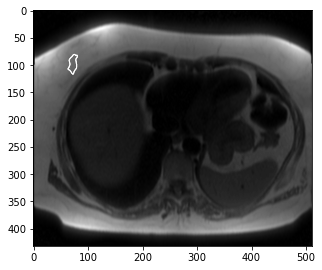

/Users/dietrichhadler/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


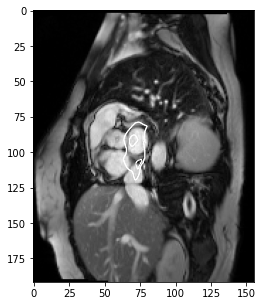

/Users/dietrichhadler/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


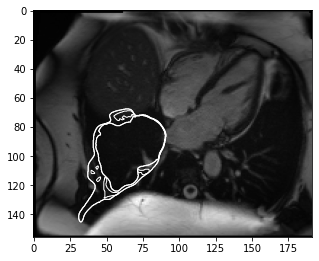

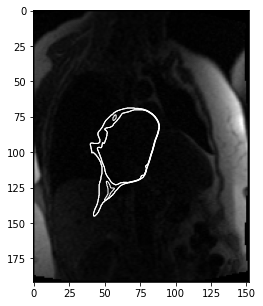

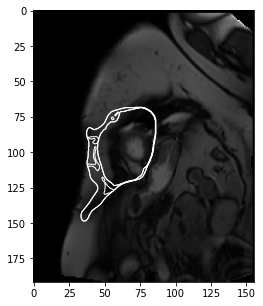

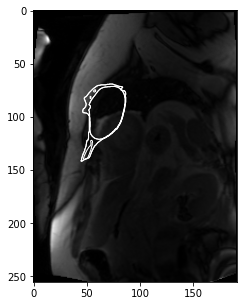

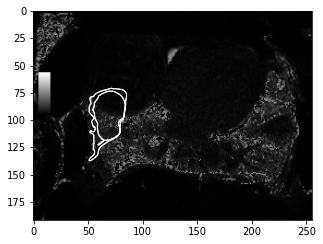

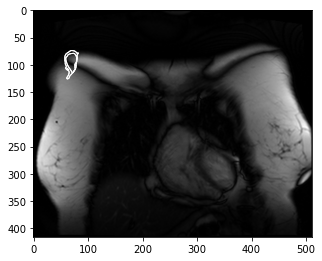

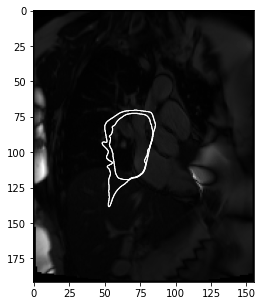

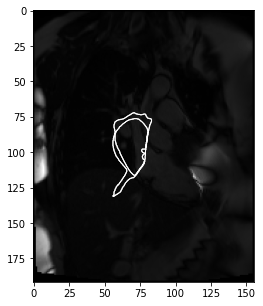

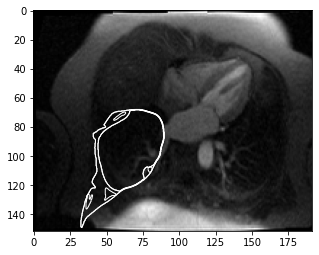

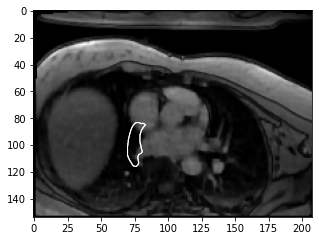

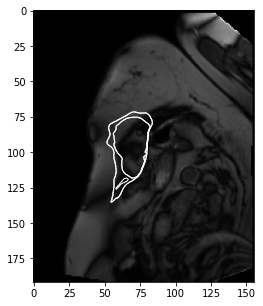

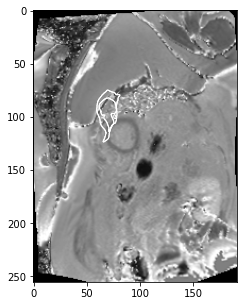

Anno:  {'info': {'imageSize': (156, 192), 'pixelSize': (1.9791666269302, 1.9791666269302)}, 'lv_myo': {'cont': <shapely.geometry.polygon.Polygon object at 0x12d4f7910>, 'contType': 'MYO', 'subpixelResolution': 4}, 'lv_epi': {'cont': <shapely.geometry.polygon.Polygon object at 0x12d4f7190>, 'contType': 'FREE', 'subpixelResolution': 4}}
lv_myo


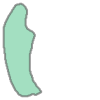

lv_epi


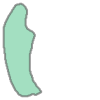

Anno:  {'info': {'imageSize': (156, 192), 'pixelSize': (1.9791666269302, 1.9791666269302)}, 'lv_myo': {'cont': <shapely.geometry.polygon.Polygon object at 0x12cc7b8e0>, 'contType': 'MYO', 'subpixelResolution': 4}, 'rv_pamu': {'cont': <shapely.geometry.polygon.Polygon object at 0x12cc7bfd0>, 'contType': 'FREE', 'subpixelResolution': 4}, 'lv_epi': {'cont': <shapely.geometry.polygon.Polygon object at 0x12cc7b730>, 'contType': 'FREE', 'subpixelResolution': 4}, 'lv_endo': {'cont': <shapely.geometry.polygon.Polygon object at 0x12cc7ba30>, 'contType': 'FREE', 'subpixelResolution': 4}}
lv_myo


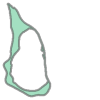

rv_pamu


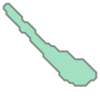

lv_epi


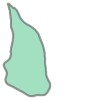

lv_endo


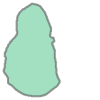

Anno:  {'info': {'imageSize': (156, 192), 'pixelSize': (1.9791666269302, 1.9791666269302)}, 'lv_myo': {'cont': <shapely.geometry.polygon.Polygon object at 0x12cc7bf70>, 'contType': 'MYO', 'subpixelResolution': 4}, 'rv_pamu': {'cont': <shapely.geometry.multipolygon.MultiPolygon object at 0x12cc7b100>, 'contType': 'FREE', 'subpixelResolution': 4}, 'lv_epi': {'cont': <shapely.geometry.polygon.Polygon object at 0x12cc7b040>, 'contType': 'FREE', 'subpixelResolution': 4}, 'lv_endo': {'cont': <shapely.geometry.polygon.Polygon object at 0x12cc7b790>, 'contType': 'FREE', 'subpixelResolution': 4}}
lv_myo


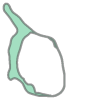

rv_pamu


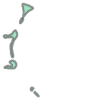

lv_epi


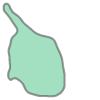

lv_endo


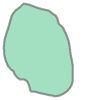

Anno:  {'info': {'imageSize': (156, 192), 'pixelSize': (1.9791666269302, 1.9791666269302)}, 'lv_myo': {'cont': <shapely.geometry.polygon.Polygon object at 0x12c3020a0>, 'contType': 'MYO', 'subpixelResolution': 4}, 'rv_pamu': {'cont': <shapely.geometry.multipolygon.MultiPolygon object at 0x12c46aaf0>, 'contType': 'FREE', 'subpixelResolution': 4}, 'lv_epi': {'cont': <shapely.geometry.polygon.Polygon object at 0x12c46a6d0>, 'contType': 'FREE', 'subpixelResolution': 4}, 'lv_endo': {'cont': <shapely.geometry.polygon.Polygon object at 0x12c46af40>, 'contType': 'FREE', 'subpixelResolution': 4}}
lv_myo


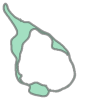

rv_pamu


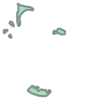

lv_epi


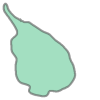

lv_endo


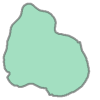

Anno:  {'info': {'imageSize': (156, 192), 'pixelSize': (1.9791666269302, 1.9791666269302)}, 'lv_myo': {'cont': <shapely.geometry.polygon.Polygon object at 0x12c46a3d0>, 'contType': 'MYO', 'subpixelResolution': 4}, 'lv_epi': {'cont': <shapely.geometry.polygon.Polygon object at 0x12c46ae50>, 'contType': 'FREE', 'subpixelResolution': 4}, 'lv_endo': {'cont': <shapely.geometry.polygon.Polygon object at 0x12c46ac70>, 'contType': 'FREE', 'subpixelResolution': 4}}
lv_myo


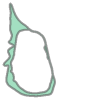

lv_epi


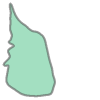

lv_endo


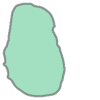

Anno:  {'info': {'imageSize': (156, 192), 'pixelSize': (1.9791666269302, 1.9791666269302)}, 'lv_myo': {'cont': <shapely.geometry.polygon.Polygon object at 0x12c46adf0>, 'contType': 'MYO', 'subpixelResolution': 4}, 'rv_pamu': {'cont': <shapely.geometry.polygon.Polygon object at 0x12c46ad60>, 'contType': 'FREE', 'subpixelResolution': 4}, 'lv_epi': {'cont': <shapely.geometry.polygon.Polygon object at 0x12c46aa30>, 'contType': 'FREE', 'subpixelResolution': 4}, 'lv_endo': {'cont': <shapely.geometry.polygon.Polygon object at 0x12c46aa00>, 'contType': 'FREE', 'subpixelResolution': 4}}
lv_myo


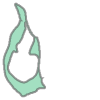

rv_pamu


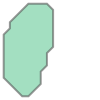

lv_epi


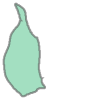

lv_endo


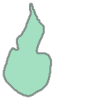

Anno:  {'info': {'imageSize': (156, 192), 'pixelSize': (1.9791666269302, 1.9791666269302)}, 'lv_myo': {'cont': <shapely.geometry.polygon.Polygon object at 0x12c46af70>, 'contType': 'MYO', 'subpixelResolution': 4}, 'rv_pamu': {'cont': <shapely.geometry.multipolygon.MultiPolygon object at 0x12c46a640>, 'contType': 'FREE', 'subpixelResolution': 4}, 'lv_epi': {'cont': <shapely.geometry.polygon.Polygon object at 0x12c46a0d0>, 'contType': 'FREE', 'subpixelResolution': 4}, 'lv_endo': {'cont': <shapely.geometry.polygon.Polygon object at 0x12c46a730>, 'contType': 'FREE', 'subpixelResolution': 4}}
lv_myo


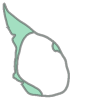

rv_pamu


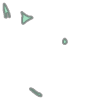

lv_epi


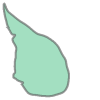

lv_endo


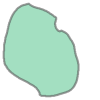

Anno:  {'info': {'imageSize': (156, 192), 'pixelSize': (1.9791666269302, 1.9791666269302)}, 'lv_myo': {'cont': <shapely.geometry.polygon.Polygon object at 0x12c46abb0>, 'contType': 'MYO', 'subpixelResolution': 4}, 'rv_pamu': {'cont': <shapely.geometry.multipolygon.MultiPolygon object at 0x12c46a6a0>, 'contType': 'FREE', 'subpixelResolution': 4}, 'lv_epi': {'cont': <shapely.geometry.polygon.Polygon object at 0x12c46a9d0>, 'contType': 'FREE', 'subpixelResolution': 4}, 'lv_endo': {'cont': <shapely.geometry.polygon.Polygon object at 0x12c46ae20>, 'contType': 'FREE', 'subpixelResolution': 4}}
lv_myo


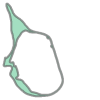

rv_pamu


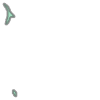

lv_epi


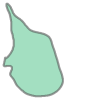

lv_endo


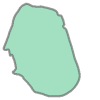

Anno:  {'info': {'imageSize': (156, 192), 'pixelSize': (1.9791666269302, 1.9791666269302)}, 'lv_myo': {'cont': <shapely.geometry.polygon.Polygon object at 0x12c46a9a0>, 'contType': 'MYO', 'subpixelResolution': 4}, 'rv_pamu': {'cont': <shapely.geometry.multipolygon.MultiPolygon object at 0x12c46a3a0>, 'contType': 'FREE', 'subpixelResolution': 4}, 'lv_epi': {'cont': <shapely.geometry.polygon.Polygon object at 0x12c46ad00>, 'contType': 'FREE', 'subpixelResolution': 4}, 'lv_endo': {'cont': <shapely.geometry.polygon.Polygon object at 0x12c46aee0>, 'contType': 'FREE', 'subpixelResolution': 4}}
lv_myo


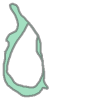

rv_pamu


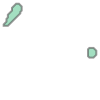

lv_epi


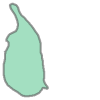

lv_endo


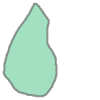

Anno:  {'info': {'imageSize': (156, 192), 'pixelSize': (1.9791666269302, 1.9791666269302)}, 'lv_myo': {'cont': <shapely.geometry.polygon.Polygon object at 0x12c46a4c0>, 'contType': 'MYO', 'subpixelResolution': 4}, 'rv_pamu': {'cont': <shapely.geometry.polygon.Polygon object at 0x12c46a130>, 'contType': 'FREE', 'subpixelResolution': 4}, 'lv_epi': {'cont': <shapely.geometry.polygon.Polygon object at 0x12c46a2b0>, 'contType': 'FREE', 'subpixelResolution': 4}, 'lv_endo': {'cont': <shapely.geometry.polygon.Polygon object at 0x12c46a370>, 'contType': 'FREE', 'subpixelResolution': 4}}
lv_myo


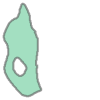

rv_pamu


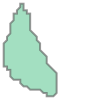

lv_epi


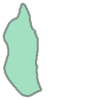

lv_endo


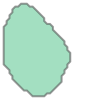

Anno:  {'info': {'imageSize': (156, 192), 'pixelSize': (1.9791666269302, 1.9791666269302)}, 'lv_myo': {'cont': <shapely.geometry.polygon.Polygon object at 0x12bbc1d90>, 'contType': 'MYO', 'subpixelResolution': 4}, 'lv_epi': {'cont': <shapely.geometry.polygon.Polygon object at 0x12bbc1f70>, 'contType': 'FREE', 'subpixelResolution': 4}, 'lv_endo': {'cont': <shapely.geometry.polygon.Polygon object at 0x12bbc1970>, 'contType': 'FREE', 'subpixelResolution': 4}}
lv_myo


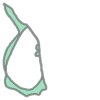

lv_epi


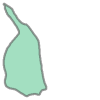

lv_endo


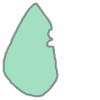

Anno:  {'info': {'imageSize': (156, 192), 'pixelSize': (1.9791666269302, 1.9791666269302)}, 'lv_myo': {'cont': <shapely.geometry.polygon.Polygon object at 0x12da7c850>, 'contType': 'MYO', 'subpixelResolution': 4}, 'rv_pamu': {'cont': <shapely.geometry.multipolygon.MultiPolygon object at 0x12da7c640>, 'contType': 'FREE', 'subpixelResolution': 4}, 'lv_epi': {'cont': <shapely.geometry.polygon.Polygon object at 0x12da7c7f0>, 'contType': 'FREE', 'subpixelResolution': 4}, 'lv_endo': {'cont': <shapely.geometry.polygon.Polygon object at 0x12da7c8b0>, 'contType': 'FREE', 'subpixelResolution': 4}}
lv_myo


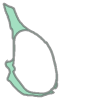

rv_pamu


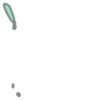

lv_epi


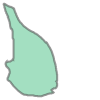

lv_endo


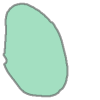

Anno:  {'info': {'imageSize': (156, 192), 'pixelSize': (1.9791666269302, 1.9791666269302)}, 'lv_myo': {'cont': <shapely.geometry.polygon.Polygon object at 0x12da7c580>, 'contType': 'MYO', 'subpixelResolution': 4}, 'lv_epi': {'cont': <shapely.geometry.polygon.Polygon object at 0x12da7cbe0>, 'contType': 'FREE', 'subpixelResolution': 4}}
lv_myo


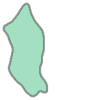

lv_epi


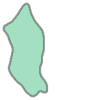

Anno:  {'info': {'imageSize': (156, 192), 'pixelSize': (1.9791666269302, 1.9791666269302)}, 'lv_myo': {'cont': <shapely.geometry.polygon.Polygon object at 0x12da7cca0>, 'contType': 'MYO', 'subpixelResolution': 4}, 'rv_pamu': {'cont': <shapely.geometry.polygon.Polygon object at 0x12da7ccd0>, 'contType': 'FREE', 'subpixelResolution': 4}, 'lv_epi': {'cont': <shapely.geometry.polygon.Polygon object at 0x12da7c5e0>, 'contType': 'FREE', 'subpixelResolution': 4}, 'lv_endo': {'cont': <shapely.geometry.polygon.Polygon object at 0x12da7c3d0>, 'contType': 'FREE', 'subpixelResolution': 4}}
lv_myo


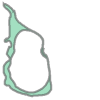

rv_pamu


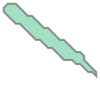

lv_epi


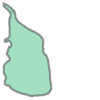

lv_endo


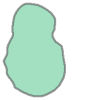

In [39]:
print(dcms.keys())
print(annos.keys())

for k in dcms.keys():
    img = dcms[k].pixel_array
    anno = annos[k]
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    ax.imshow(img, cmap='gray')
    anno.plot_all_contour_outlines(ax)
    plt.show()

In [11]:
sd = 'stanre_rs3dt2d_1111_iiNav_IRprep_Dixon-TRA_Acc3.5_GMDMocoCGSense_W_tf2d14 _retro_iPAT_ sax + RV 7 0_FF'
dcms2 = []
for ip, p in enumerate(Path(imgp).glob('**/*.dcm')):
    try:
        p = str(p)
        dcm = pydicom.dcmread(p, stop_before_pixels=True)
        if dcm.SeriesDescription == sd:
            dcm = pydicom.dcmread(p, stop_before_pixels=False)
            dcms2.append(dcm)
    except:
        pass
dcms2 = sorted(dcms2, key=lambda x: float(x.SliceLocation))
dcms_tmp = dict()
for sop in dcms.keys():
    dcm = dcms[sop]
    slloc = dcm.SliceLocation
    for dcm2 in dcms2:
        if dcm2.SliceLocation==slloc:
            dcms_tmp[sop] = dcm2
dcms2 = dcms_tmp
print(len(dcms2))

0


In [ ]:
for sop in dcms.keys():
    try:
        img1 = dcms[sop].pixel_array
        img2 = dcms2[sop].pixel_array
        h, w = img1.shape
        anno = annos[sop]
        fig, axes = plt.subplots(1,2, figsize=(10,15))
        extent=(0, w, h, 0)
        axes[0].imshow(img1, cmap='gray', extent=extent); axes[0].axis('off')
        axes[1].imshow(img2, cmap='gray', extent=extent); axes[1].axis('off')
        anno.plot_all_contour_outlines(axes[0])
        anno.plot_all_contour_outlines(axes[1], 'r')
        for ax in axes: ax.set_xlim([20, 150]); ax.set_ylim([50, 150]); 
        plt.show()
    except Exception as e:
        print(e)


In [ ]:
class FF_Category:
    def __init__(self, dcms_fat, dcms_ff, annos):
        self.dcms_fat  = dcms_fat 
        self.dcms_ff   = dcms_ff
        self.annos     = annos
        self.depth2sop = self.sort_sops_2_depth(dcms_fat)
        self.nr_slices = len(self.depth2sop.values())
        self.set_params()
        
    def set_params(self):
        dcm1, dcm2 = self.get_fat_dcm(0), self.get_fat_dcm(1)
        self.slice_thickness = dcm1.SliceThickness
        self.spacing_between_slices = np.abs(dcm1.SliceLocation - dcm2.SliceLocation)
        self.ph, self.pw = dcm1.PixelSpacing
        
    def sort_sops_2_depth(self, dcms):
        sl_locs = [(dcm.SOPInstanceUID, float(dcm.SliceLocation)) for dcm in dcms.values()]
        sl_locs = sorted(sl_locs, key=lambda x:x[1])
        depth2sop = {i:x[0] for i,x in enumerate(sl_locs)}
        return depth2sop
        
    def get_fat_dcm(self, depth): return self.dcms_fat[self.depth2sop[depth]]
    def get_ff_dcm (self, depth): return self.dcms_ff[self.depth2sop[depth]]
    def get_fat_img(self, depth): return self.get_fat_dcm(depth).pixel_array
    def get_ff_img (self, depth): return self.get_ff_dcm(depth).pixel_array
    def get_anno   (self, depth): return self.annos[self.depth2sop[depth]]
    
    def get_ff_in_myo(self, depth):
        ff_cont = utils.to_polygon(self.get_ff_img(depth))
        anno = self.get_anno(depth)
        pixels_inside_myo = anno.get_contour('lv_myo').intersection(ff_cont)
        pixels_inside_myo = utils.geometry_collection_to_Polygon(pixels_inside_myo)
        return pixels_inside_myo
    
    # in ml
    def get_ff_volume(self):
        dcm_tmp = self.get_ff_dcm(0)
        ph, pw = self.ph, self.pw
        annos = [self.get_ff_in_myo(d) for d in range(self.nr_slices)]
        areas = [self.get_ff_in_myo(d).area for d in range(self.nr_slices)]
        has_conts = [a!=0 for a in areas]
        top_idx, bot_idx  = has_conts.index(True), self.nr_slices-has_conts[::-1].index(True)-1
        total_vol = 0
        for d in range(self.nr_slices):
            area = self.get_ff_in_myo(d).area - anno.get_contour('rv_pamu').area
            pd   = (self.slice_thickness+self.spacing_between_slices)/2 if d in [top_idx, bot_idx] else self.spacing_between_slices
            total_vol += ph * pw * pd * area
        return total_vol / 1000
    
    # in ml
    def get_fat_volume(self):
        dcm_tmp = self.get_fat_dcm(0)
        ph, pw = self.ph, self.pw
        annos = [self.get_anno(d) for d in range(self.nr_slices)]
        areas = [a.get_contour('lv_myo').area if a is not None else 0.0 for a in annos]
        has_conts = [a!=0 for a in areas]
        top_idx, bot_idx  = has_conts.index(True), self.nr_slices-has_conts[::-1].index(True)-1
        total_vol = 0
        for d in range(self.nr_slices):
            anno = self.get_anno(d)
            area = anno.get_contour('lv_myo').area - anno.get_contour('rv_pamu').area
            pd   = (self.slice_thickness+self.spacing_between_slices)/2 if d in [top_idx, bot_idx] else self.spacing_between_slices
            total_vol += ph * pw * pd * area
        return total_vol / 1000
    
    def get_area_table(self):
        rows = []
        ph, pw = self.ph, self.pw
        pd = self.spacing_between_slices
        for d in range(self.nr_slices):
            anno = self.get_anno(d)
            area1 = ph*pw*(anno.get_contour('lv_myo').area - anno.get_contour('rv_pamu').area)
            area2 = ph*pw*self.get_ff_in_myo(d).area
            vol1  = pd * area1
            rows.append([area1, pd*area1/1000, area2, pd*area2/1000])
        cols = ['Fat Areas [mm^2]', 'Fat Volume [ml]', 'FF Areas [mm^2]', 'FF Volume [ml]']
        return DataFrame(rows, columns=cols)
    
    def get_cr_table(self):
        rows = [[cat.get_fat_volume(), cat.get_ff_volume()]]
        cols = ['Fat Volume [ml]', 'FF Volume [ml]']
        return DataFrame(rows, columns=cols)
    
    def store_tables(self, folder_path, case_name):
        df = self.get_cr_table()
        path = os.path.join(folder_path, case_name+'_clinical_result.csv')
        pandas.DataFrame.to_csv(df, path, sep=';', decimal=',')
        df = self.get_area_table()
        path = os.path.join(folder_path, case_name+'_areas.csv')
        pandas.DataFrame.to_csv(df, path, sep=';', decimal=',')

cat = FF_Category(dcms, dcms2, annos)

display(cat.get_area_table())
display(cat.get_cr_table())
cat.store_tables(folder_path=bp_cases)

In [ ]:
path = os.path.join(bp_cases, 'test_cat.pickle')
pickle.dump(cat, open(path, 'wb'), pickle.HIGHEST_PROTOCOL)

In [ ]:
new_cat = pickle.load(open(path, 'rb'))
cat = new_cat

In [ ]:
for d in range(cat.nr_slices):
    fig, axes = plt.subplots(1,3, figsize=(20,9))
    img    = cat.get_fat_img(d)
    h, w   = img.shape
    ph, pw = cat.ph, cat.pw
    extent = (0, w, h, 0)
    axes[0].imshow(cat.get_fat_img(d), cmap='gray', extent=extent); axes[0].axis('off')
    axes[1].imshow(cat.get_ff_img(d) , cmap='gray', extent=extent); axes[1].axis('off')
    axes[2].imshow(cat.get_ff_img(d) , cmap='gray', extent=extent); axes[2].axis('off')
    anno = cat.get_anno(d)
    anno.plot_contour_face(axes[0], 'lv_myo')
    anno.plot_contour_face(axes[0], 'rv_pamu', 'b')
    #anno.plot_contour_face(axes[1], 'lv_myo')
    anno.plot_contour_face(axes[1], 'lv_epi')
    #anno.plot_contour_face(axes[1], 'rv_pamu', 'b')
    ff_pixel_polygon = cat.get_ff_in_myo(d)
    utils.plot_outlines(axes[2], ff_pixel_polygon, 'r')
    for ax in axes:
        ax.set_xlim([20, 150]); ax.set_ylim([50, 150]); 
    print(d)
    #pixel_area = ph*pw
    pixel_area = 1
    print(pixel_area*(anno.get_contour('lv_myo').area - anno.get_contour('rv_pamu').area))
    print(pixel_area*(ff_pixel_polygon.area))
    fig.tight_layout()
    plt.show()